In [23]:

from catboost import CatBoostClassifier

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [24]:


X_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train_Df64byy.csv")
X_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_YCcRUnU.csv")



In [25]:
y = X_train["Response"]
X_train = X_train.drop(["ID","Response"],axis=1)

X_test = X_test.drop(["ID"],axis=1)

In [26]:
X_train.shape, X_test.shape

((50882, 12), (21805, 12))

In [27]:
all_data = pd.concat([X_train, X_test]).reset_index(drop=True)
all_data.shape

(72687, 12)

In [28]:
all_data.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium'],
      dtype='object')

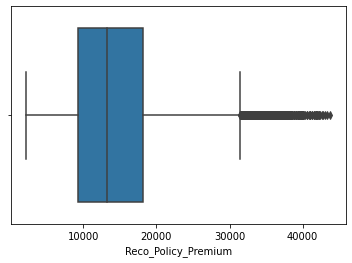

In [29]:

ap_boxplot_bf = plt.subplot()
ap_boxplot_bf = sns.boxplot(
    x = 'Reco_Policy_Premium',
    data = all_data
)
plt.show()

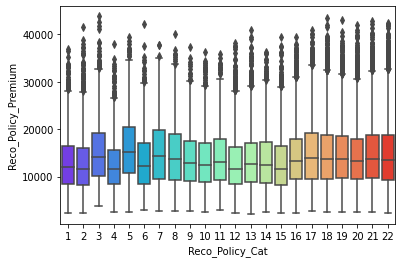

In [30]:

# sns.catplot(x="Response", y="Holding_Policy_Type", data=all_data)
# sns.countplot(x='Region_Code',data=all_data[all_data['City_Code']=='C15'])
sns.boxplot(x='Reco_Policy_Cat',y='Reco_Policy_Premium',data=all_data,palette='rainbow')

In [31]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
print(all_data_na)

City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator           22.999986
Holding_Policy_Duration    39.696232
Holding_Policy_Type        39.696232
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
dtype: float64


In [32]:

def custom_rating(dur):
    if dur=="14+":
        return int(5)
    elif int(float(dur))==0:
        return 0
    elif int(float(dur))>=1 and int(float(dur))<4:
        return 1
    elif int(float(dur))>=4 and int(float(dur))<8:
        return 2
    elif int(float(dur))>=8 and int(float(dur))<11:
        return 3
    elif int(float(dur))>=11 and int(float(dur))<=14:
        return 4

In [33]:
#fill null values
all_data["Health Indicator"] = all_data["Health Indicator"].fillna("None")
all_data["Holding_Policy_Duration"] = all_data["Holding_Policy_Duration"].fillna(0)
all_data['Holding_Policy_Duration'] = all_data['Holding_Policy_Duration'].apply(lambda x: custom_rating(x)).astype(str)
all_data["Holding_Policy_Type"] = all_data["Holding_Policy_Type"].fillna("None").astype(str)

#convert into categorical values
all_data["Reco_Policy_Cat"] = all_data["Reco_Policy_Cat"].astype(str)
all_data["Region_Code"] = all_data["Region_Code"].astype(str)

In [34]:
#Reco policy premium is taken as per person in new column(assuming 2 person in joint)
all_data['Reco_Policy_Premium_original'] = all_data['Reco_Policy_Premium']
all_data.loc[all_data['Reco_Insurance_Type']=='Joint','Reco_Policy_Premium'] = all_data[all_data['Reco_Insurance_Type']=='Joint']['Reco_Policy_Premium'].apply(lambda x: x/2.0 )

In [35]:

cat_columns=[]
for col in all_data.select_dtypes('object').columns:
  print(col)
  cat_columns.append(col)
  le = LabelEncoder()
  all_data[col] = le.fit_transform(all_data[col])

City_Code
Region_Code
Accomodation_Type
Reco_Insurance_Type
Is_Spouse
Health Indicator
Holding_Policy_Duration
Holding_Policy_Type
Reco_Policy_Cat


In [36]:
X_test_final = all_data[len(y):]
all_data = all_data[:len(y)]

In [37]:
all_data.shape,X_test.shape

((50882, 13), (21805, 12))

In [38]:
all_data.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium', 'Reco_Policy_Premium_original'],
      dtype='object')

In [39]:
print(all_data.shape,all_data.columns)


X_train,X_test,y_train,y_test = train_test_split(all_data,y,test_size=0.2,random_state=42)

(50882, 13) Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium', 'Reco_Policy_Premium_original'],
      dtype='object')


In [40]:
cat_features_index = [i for i,col in enumerate(all_data.columns) if col in cat_columns]
cat_features_index

[0, 1, 2, 3, 6, 7, 8, 9, 10]

In [41]:
# model = CatBoostClassifier(iterations=100,learning_rate=0.1,class_weights=[0.2, 0.8],'eval_metric': 'AUC')
model = CatBoostClassifier(iterations=1000,eval_metric= 'AUC',early_stopping_rounds=300,cat_features = cat_features_index)

In [42]:
model.fit(X_train,y_train)
# model.fit(X_train,y_train['Response'],cat_features = categorical_var)

Learning rate set to 0.050148
0:	total: 125ms	remaining: 2m 4s
1:	total: 187ms	remaining: 1m 33s
2:	total: 245ms	remaining: 1m 21s
3:	total: 311ms	remaining: 1m 17s
4:	total: 375ms	remaining: 1m 14s
5:	total: 393ms	remaining: 1m 5s
6:	total: 435ms	remaining: 1m 1s
7:	total: 490ms	remaining: 1m
8:	total: 543ms	remaining: 59.8s
9:	total: 590ms	remaining: 58.4s
10:	total: 609ms	remaining: 54.8s
11:	total: 661ms	remaining: 54.4s
12:	total: 725ms	remaining: 55.1s
13:	total: 777ms	remaining: 54.7s
14:	total: 835ms	remaining: 54.8s
15:	total: 905ms	remaining: 55.7s
16:	total: 957ms	remaining: 55.3s
17:	total: 988ms	remaining: 53.9s
18:	total: 1.04s	remaining: 53.6s
19:	total: 1.09s	remaining: 53.3s
20:	total: 1.11s	remaining: 51.7s
21:	total: 1.16s	remaining: 51.8s
22:	total: 1.24s	remaining: 52.6s
23:	total: 1.29s	remaining: 52.4s
24:	total: 1.35s	remaining: 52.6s
25:	total: 1.41s	remaining: 52.9s
26:	total: 1.47s	remaining: 52.9s
27:	total: 1.52s	remaining: 52.7s
28:	total: 1.56s	remaining:

In [43]:

ypred1 = model.predict_proba(X_test)
print(roc_auc_score(y_test,ypred1[:,1] ))

0.8034683512763128


In [52]:
names = all_data.columns
# feat_final = sorted(zip(map(lambda x: round(x, 4), model.feature_importances_),names ), reverse=False)
# feat_final
df = pd.DataFrame()
df['names'] = names
df['feat_imp'] = model.feature_importances_


,names,feat_imp
0,City_Code,11.575661
1,Region_Code,23.339155
2,Accomodation_Type,0.586341
3,Reco_Insurance_Type,0.201680
4,Upper_Age,2.587616
5,Lower_Age,3.086536
6,Is_Spouse,0.320086
7,Health Indicator,5.029470
8,Holding_Policy_Duration,4.265320
9,Holding_Policy_Type,6.006698


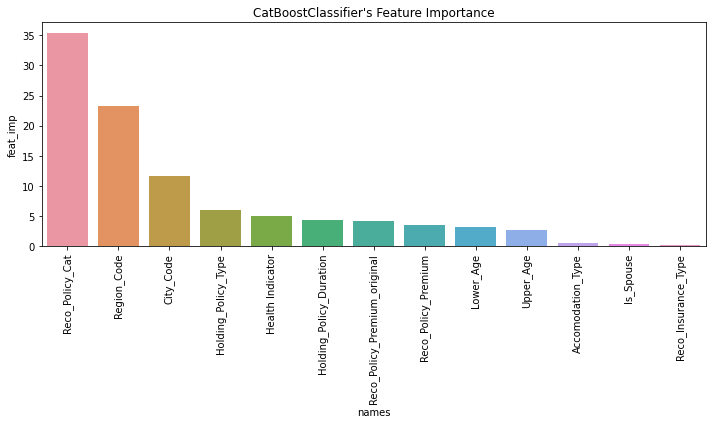

In [64]:
plt.figure(figsize=(10, 6)) 
sns.barplot(x="names", y="feat_imp", data=df.sort_values(by="feat_imp", ascending=False))
plt.title("CatBoostClassifier's Feature Importance")
plt.xticks(rotation='vertical')
plt.tight_layout()